In [12]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import random
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split
import time

## Define paramaters for the model
learning_rate = 0.5
n_epochs = 100
batch_size = 50
hidden_size = 50
# regulation_rate = 1e-4

def fullLayer(input_data, output_size, act, std = 0.1):    
    ##defining the full linear Layer here
    w = tf.Variable(tf.random_normal([input_data.get_shape().as_list()[1], output_size], stddev = std))
    b = tf.Variable(tf.zeros([output_size]))
    return act(tf.matmul(input_data, w) + b), w, b


##read data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

    
tf.reset_default_graph()
##define placeholder
## all image are 28 * 28 so x has 784 dimension
X = tf.placeholder(tf.float32, [batch_size, 784], name='X_placeholder')
Y = tf.placeholder(tf.float32, [batch_size, 10], name='Y_placeholder')

## the layers
h, w1, b1 = fullLayer(X, hidden_size, tf.nn.sigmoid)
logits, w2, b2 = fullLayer(h, 10, tf.nn.sigmoid)

## defining loss function
## use cross entropy of softmax of logits as the loss function
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
## computes the mean over all the examples in the batch
loss = tf.reduce_mean(entropy) 
# + regulation_rate*tf.nn.l2_loss(w)  

##defining optimizer
## using gradient descent with learning rate of 0.5 to minimize loss
gradient = tf.train.GradientDescentOptimizer(learning_rate)
optimizer = gradient.minimize(loss)

##the prediction we made
preds = tf.nn.softmax(logits)
##check how many of them are correct arg maxx is used because Y is one hat
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

best_acc = 0
best_hidden = 0

##just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
with tf.Session(config = config) as sess:
    ## to visualize using TensorBoard
    #writer = tf.summary.FileWriter('./graphs/mnist/c', sess.graph)
    ####cross validation
    ##starting time
    start_time = time.time()
    ##initialize the variables
    sess.run(tf.global_variables_initializer())
    
    ##split 10 percentage of data randomly for validation
    X_train, X_validation, Y_train, Y_validation = train_test_split(mnist.train.images, mnist.train.labels, test_size=0.1, random_state=42)
   
    ##the epoch with best accuracy neccessary parameters
    best_acc = 0
    best_w1 = 0
    best_w2 = 0
    best_b1 = 0
    best_b2 = 0
    best_epoch = 0
    best_loss = 10000
    
    n_batches = int(len(X_train) / batch_size)
    losses = []
    for i in range(n_epochs):  # train the model n_epochs times
        total_loss = 0
        total_acc = 0
        for j in range(n_batches):
            ## define batches for training
            X_batch =  X_train[j * batch_size:(j+1) * batch_size]
            Y_batch =  Y_train[j * batch_size:(j+1) * batch_size]
        
            _, loss_batch, acc_batch = sess.run([optimizer, loss, accuracy], feed_dict={X: X_batch, Y: Y_batch})
            
            total_loss += loss_batch
            total_acc += acc_batch
        #### this is early stopping:
        if i - best_epoch > 10:
            break
        if i % 5 == 4:
            print('epoch {}, Average loss : {}, Accuracy : {:.6f}'.format( i, total_loss / n_batches, total_acc / mnist.train.num_examples))
            val_acc = 0
            val_loss = 0
            
            ## define number of validation batches
            n_batches_validation = int(len(X_validation) / batch_size) 
            for j in range(n_batches_validation):
                ## define batches for validation
                X_batch, Y_batch = X_validation[i * batch_size:(i+1) * batch_size], Y_validation[i * batch_size:(i+1) * batch_size]
                accuracy_batch, loss_batch = sess.run([accuracy, loss], feed_dict={X: X_batch, Y: Y_batch})
                val_acc += accuracy_batch
                val_loss += loss_batch
                
            ##if accuracy is better than best accuracy
            if(best_loss > val_loss / len(X_validation)):
                ##parameters needed for checking the test accuracy
                best_loss = val_loss / len(X_validation)
                best_w1 = sess.run(w1)
                best_b1 = sess.run(b1)
                best_w2 = sess.run(w2)
                best_b2 = sess.run(b2)
                best_epoch = i
            
                
            print('Validation Loss {:.6f}'.format( float(val_loss) /len(X_validation)))
            losses.append(val_loss / len(X_validation))
            
    print('Total time: {0} seconds'.format(time.time() - start_time))
    print('Optimization Finished!')   
sess.close()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
epoch 4, Average loss : 1.557112583487925, Accuracy : 0.823382
Validation Loss 0.030903
epoch 9, Average loss : 1.533071398373806, Accuracy : 0.838218
Validation Loss 0.031272
epoch 14, Average loss : 1.5223491539858809, Accuracy : 0.846182
Validation Loss 0.030417
epoch 19, Average loss : 1.5154142193119935, Accuracy : 0.851964
Validation Loss 0.031337
epoch 24, Average loss : 1.510401629438304, Accuracy : 0.855745
Validation Loss 0.030264
epoch 29, Average loss : 1.506525373338449, Accuracy : 0.858764
Validation Loss 0.030784
epoch 34, Average loss : 1.5033882210953067, Accuracy : 0.861364
Validation Loss 0.030146
epoch 39, Average loss : 1.500763205687205, Accuracy : 0.863727
Validation Loss 0.030581
epoch 44, Average loss : 1.4985341358666469, Accuracy : 0.865618
Validation Loss 0.029918
epo

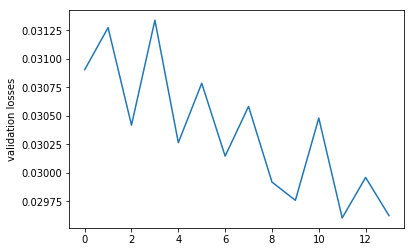

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel("validation losses")
plt.show()
'''
    خطای ولدیشن به صورت میانگین اول در حال کاهش است اما از یک جایی به بعد زیاد میشود اما چون ما زود ایست میکنیم در نمودار دیده نمی شود
'''

In [14]:
tf.reset_default_graph()
#define placeholder
# # all image are 28 * 28 so x has 784 dimension
X = tf.placeholder(tf.float32, [batch_size, 784], name='X_placeholder')
Y = tf.placeholder(tf.float32, [batch_size, 10], name='Y_placeholder')

#layers
h = tf.nn.sigmoid(tf.matmul(X,best_w1) + best_b1)
logits = tf.nn.sigmoid(tf.matmul(h,best_w2) + best_b2)

# defining loss function
# use cross entropy of softmax of logits as the loss function
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y, name='loss')
loss = tf.reduce_mean(entropy) # computes the mean over all the examples in the batch
# + regulation_rate*tf.nn.l2_loss(w)  

#the prediction we made
preds = tf.nn.softmax(logits)
#check how many of them are correct arg maxx is used because Y is one hat
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

#just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)

## testing
with tf.Session() as sess:
    ## number of test batches
    n_batches = int(mnist.test.num_examples / batch_size)
    total_correct_preds = 0
    for i in range(n_batches):
        ## test batches
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        accuracy_batch = sess.run([accuracy], feed_dict={X: X_batch, Y: Y_batch})
        total_correct_preds += accuracy_batch[0]
    print('Validation Accuracy hidden_size {}, {}'.format(best_hidden, total_correct_preds / mnist.test.num_examples))
sess.close()

Validation Accuracy hidden_size 0, 0.9589
